In [1]:
from pathlib import Path
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
from rasterio import features
import rasterio as rio
from tqdm.auto import tqdm
from shapely.geometry import shape, box
import pandas as pd
from multiprocessing import Pool
from shapely.geometry import box
from shapely.geometry import Polygon
from functools import partial

In [2]:
model_name = "regnety_002_v1.26_model"

In [3]:
# Path the the inference rasters
input_rasters = Path("/media/nick/SNEAKERNET/inference_scenes_5")

In [4]:
rasters = list(input_rasters.glob("*pred.tif"))
len(rasters)

24

In [5]:
# set the output path
output_vector = input_rasters / f"{model_name}.gpkg"
output_vector

PosixPath('/media/nick/SNEAKERNET/inference_scenes_5/regnety_002_v1.26_model.gpkg')

In [6]:
# simplify the geometries to make them less blocky
def simplify_geometries(gdf: gpd.GeoDataFrame, tolerance: float) -> gpd.GeoDataFrame:
    new_gdf = gdf.copy()
    new_gdf["geometry"] = new_gdf["geometry"].simplify(
        tolerance, preserve_topology=False
    )
    return gpd.GeoDataFrame(new_gdf)

In [7]:
# extract the polygons from the rasters and reproject them to 3857
def extract_polygons(chunk, px_size):
    with rio.open(chunk) as src:
        local_epsg = src.meta["crs"].to_epsg()
        water_array = src.read(1).astype("uint8")
        mask = water_array == 1

    shapes = features.shapes(
        water_array, mask=mask, transform=src.transform, connectivity=4
    )
    water_array = None
    geoms = []
    values = []
    for shapedict, value in shapes:
        geoms.append(shape(shapedict))
        values.append(value)

    water_gdf = gpd.GeoDataFrame({"geometry": geoms}, crs=f"EPSG:{local_epsg}")
    water_gdf = simplify_geometries(water_gdf, px_size)

    water_gdf_wgs = water_gdf.to_crs(3857)

    water_gdf_wgs["geometry"] = water_gdf_wgs.buffer(0)

    return water_gdf_wgs

In [8]:
# get the raster bounds in 3857
def get_raster_bounds(raster):
    with rio.open(raster) as src:
        bounds = box(*src.bounds)
        bounds = gpd.GeoDataFrame({"geometry": [bounds]}, crs=src.crs).to_crs(3857)
    return bounds

In [9]:
# get all bounds and dissolve them, we will use this as a mask later to remove the edge lines
with Pool() as p:
    raster_bounds = list(tqdm(p.imap(get_raster_bounds, rasters), total=len(rasters)))
bounds_gdf = gpd.GeoDataFrame(pd.concat(raster_bounds), crs=3857).dissolve()

  0%|          | 0/24 [00:00<?, ?it/s]

<Axes: >

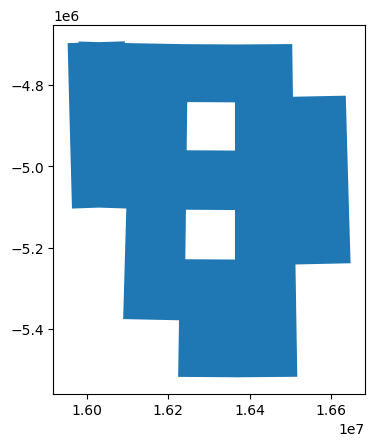

In [10]:
bounds_gdf.plot()

In [11]:
# water_polygons = []
# for i in rasters:
#     water_polygons.append(extract_polygons(i, px_size=10))

extract_polygons_partial = partial(extract_polygons, px_size=10)
with Pool() as p:
    water_polygons = list(
        tqdm(p.imap(extract_polygons_partial, rasters), total=len(rasters))
    )

  0%|          | 0/24 [00:00<?, ?it/s]

In [12]:
# join all chunks into one gdf and dissolve
joined_water_gdf = pd.concat(water_polygons, ignore_index=True)
joined_water_gdf_dis = joined_water_gdf.dissolve()
joined_water_gdf_dis

,geometry
0,"MULTIPOLYGON (((16377595.030 -5518427.784, 163..."


<Axes: >

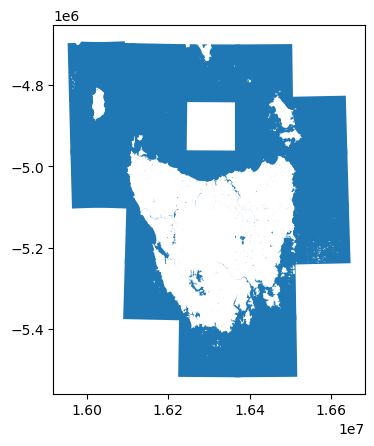

In [13]:
joined_water_gdf.plot()

In [14]:
# convert multipart poly to single part so we can sort by size to remove lakes and rivers
single_part_gdf = joined_water_gdf_dis.explode(index_parts=False)
single_part_gdf["area"] = single_part_gdf.area
# only keep the largest area polygon
single_part_gdf = single_part_gdf.sort_values("area", ascending=False)
single_part_gdf = single_part_gdf.iloc[[0]]
single_part_gdf

,geometry,area
0,"POLYGON ((16377595.030 -5518427.784, 16370766....",2.945027e+11


In [15]:
# convert to lines to get the coastline
single_part_gdf.geometry = single_part_gdf.boundary
single_part_gdf

,geometry,area
0,"MULTILINESTRING ((16377595.030 -5518427.784, 1...",2.945027e+11


<Axes: >

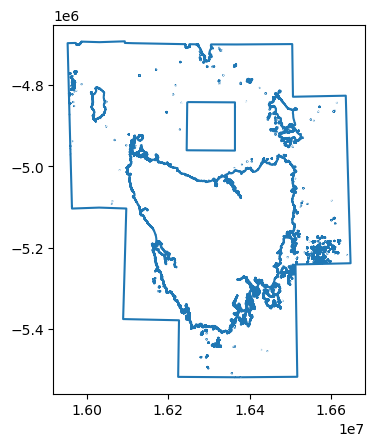

In [16]:
single_part_gdf.plot()

<Axes: >

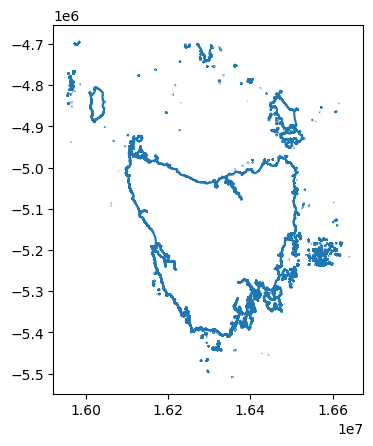

In [17]:
# clip coastline to the bounds of the rasters to remove the edge lines
clipped_gdf = gpd.clip(single_part_gdf, bounds_gdf.buffer(-500)).explode(
    index_parts=False
)
clipped_gdf.plot()

In [18]:
def chaikin_corner_cutting_optimized(
    points: np.ndarray, num_iterations: int = 1
) -> np.ndarray:
    for _ in range(num_iterations):
        if np.array_equal(points[0], points[-1]):
            points = np.append(points, [points[1]], axis=0)

        p0 = points[:-1]
        p1 = points[1:]
        q = p0 * 0.75 + p1 * 0.25
        r = p0 * 0.25 + p1 * 0.75
        new_points = np.empty((2 * len(points) - 2, points.shape[1]))
        new_points[0::2] = q
        new_points[1::2] = r

        if np.array_equal(points[0], points[-2]):
            new_points = new_points[1:]
            new_points = np.append(new_points, [new_points[0]], axis=0)
        else:
            new_points = np.append(new_points, [points[-1]], axis=0)

        points = new_points

    return points


def smooth_geodataframe_optimized(
    gdf: gpd.GeoDataFrame, num_iterations: int = 1
) -> gpd.GeoDataFrame:
    gdf["geometry"] = gdf["geometry"].apply(
        lambda line: LineString(
            chaikin_corner_cutting_optimized(
                np.array(line.coords), num_iterations=num_iterations
            )
        )
    )

    return gdf

In [19]:
# smooth all the lines
lines_gpd = smooth_geodataframe_optimized(clipped_gdf, num_iterations=2)
lines_gpd

,area,geometry
0,2.945027e+11,"LINESTRING (15972141.954 -4696646.677, 1597217..."
0,2.945027e+11,"LINESTRING (16241412.139 -4699711.464, 1624140..."
0,2.945027e+11,"LINESTRING (16269176.782 -4699890.434, 1626919..."
0,2.945027e+11,"LINESTRING (16271135.130 -4699899.342, 1627113..."
0,2.945027e+11,"LINESTRING (16272625.863 -4699900.217, 1627266..."
...,...,...
0,2.945027e+11,"LINESTRING (16509564.708 -5058109.185, 1650957..."
0,2.945027e+11,"LINESTRING (16507019.961 -5037045.472, 1650702..."
0,2.945027e+11,"LINESTRING (16505313.128 -5059800.444, 1650532..."
0,2.945027e+11,"LINESTRING (16503734.432 -5060371.757, 1650374..."


In [20]:
lines_gpd.to_file(output_vector)

In [21]:
output_vector

PosixPath('/media/nick/SNEAKERNET/inference_scenes_5/regnety_002_v1.26_model.gpkg')